In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [52]:
dataset = tf.data.Dataset.range(10)

for val in dataset:
  print(val.numpy())

0
1
2
3
4
5
6
7
8
9


In [50]:
dataset= dataset.window(size=5, shift=1)

for window in dataset:
  for val in window:
    print(val.numpy(), end = " ")
  print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


In [53]:
dataset= dataset.window(size=5, shift=1, drop_remainder=True)

for window in dataset:
  for val in window:
    print(val.numpy(), end = " ")
  print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


In [54]:
dataset = dataset.flat_map(lambda window: window.batch(5))

for win in dataset:
  print(win.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [55]:
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
for x,y in dataset:
  print("X=", x.numpy())
  print("y=", y.numpy())

X= [0 1 2 3]
y= 4
X= [1 2 3 4]
y= 5
X= [2 3 4 5]
y= 6
X= [3 4 5 6]
y= 7
X= [4 5 6 7]
y= 8
X= [5 6 7 8]
y= 9


In [56]:
dataset = dataset.shuffle(buffer_size=10)

for x,y in dataset:
  print("X=", x.numpy())
  print("y=", y.numpy())

X= [1 2 3 4]
y= 5
X= [3 4 5 6]
y= 7
X= [4 5 6 7]
y= 8
X= [2 3 4 5]
y= 6
X= [0 1 2 3]
y= 4
X= [5 6 7 8]
y= 9


In [57]:
dataset = dataset.batch(2)

for x,y in dataset:
  print("X=", x.numpy())
  print("y=", y.numpy())

X= [[2 3 4 5]
 [3 4 5 6]]
y= [6 7]
X= [[0 1 2 3]
 [1 2 3 4]]
y= [4 5]
X= [[4 5 6 7]
 [5 6 7 8]]
y= [8 9]


In [58]:
def plot_series(time, series, format="-", start=0, end=None):

    plt.figure(figsize=(10, 6))
    if type(series) is tuple:

      for series_num in series:

        plt.plot(time[start:end], series_num[start:end], format)
    else:
      plt.plot(time[start:end], series[start:end], format)

    plt.xlabel("Time")
    plt.ylabel("Value")

    plt.grid(True)
    plt.show()



In [59]:
def trend(time, slope=0):

    series = slope * time

    return series


In [60]:
def seasonal_pattern(season_time):

    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern


In [61]:
def seasonality(time, period, amplitude=1, phase=0):

    season_time = ((time + phase) % period) / period
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern



In [62]:
def noise(time, noise_level=1, seed=None):

    rnd = np.random.RandomState(seed)
    noise = rnd.randn(len(time)) * noise_level

    return noise


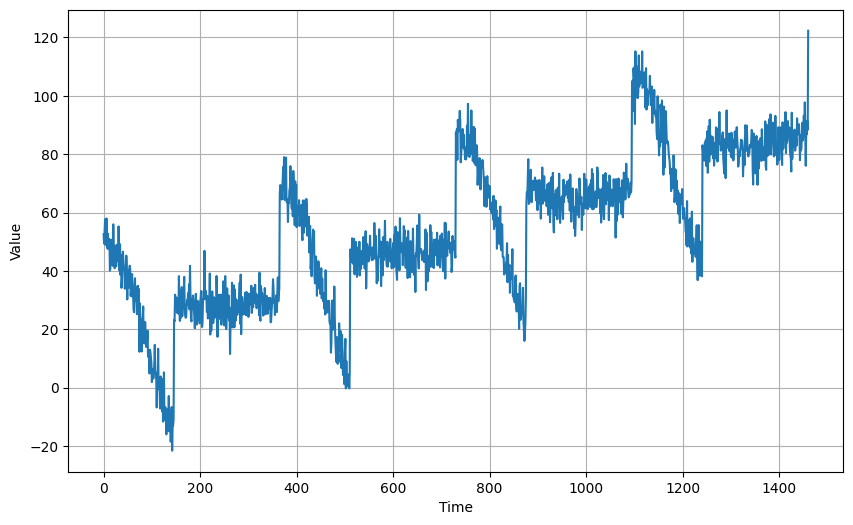

In [63]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)


plot_series(time, series)


In [64]:
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]


In [65]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000


In [66]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    dataset = dataset.shuffle(shuffle_buffer)

    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset



In [67]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [68]:
for x,y in dataset:
  print("X=", x.numpy())
  print("y=", y.numpy())

X= [[23.959423   22.945732   34.834587   33.029884   32.21989    32.268925
  29.094048   24.697277   29.591013   25.8548     34.145004   28.563086
  25.200027   27.749893   31.45096    26.59733    25.334665   30.694183
  30.730724   27.001482  ]
 [32.115417   26.488426   31.91241    29.26776    20.18714    35.023605
  35.793324   23.285662   23.954716   26.874273   26.67722    27.866035
  34.201256   22.851107   19.33878    16.03705    18.891466   22.002163
  30.77161    63.25971   ]
 [43.965313   47.50264    56.41485    50.378082   44.37749    51.99936
  43.93912    35.775608   40.91304    36.58728    44.171944   46.010376
  54.289753   47.53197    44.792107   50.02539    34.813927   47.039402
  49.707848   38.453266  ]
 [84.53093    79.05104    86.569954   79.90539    83.09848    94.98353
  81.38736    87.288605   77.69104    80.686905   89.36113    77.00803
  88.83144    82.92502    76.18184    81.7551     83.04582    80.873344
  69.48581    73.26541   ]
 [53.083527   64.105736   56

In [69]:
model_baseline = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])


model_baseline.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 10)                210       
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [70]:
model_baseline.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

In [71]:
model_baseline.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 802.7702
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 97.6707
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 81.1899
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 78.6119
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 76.2267
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 73.8421
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 72.0733
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 70.2607
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 68.5896
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 67.1156
Epoch 11/100
31/31 [==============================] - 0s 1ms/step - loss: 65.9889
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 64.8172
Epoch 13/100
31/31 [====

1/1 [==============================] - 0s 24ms/step


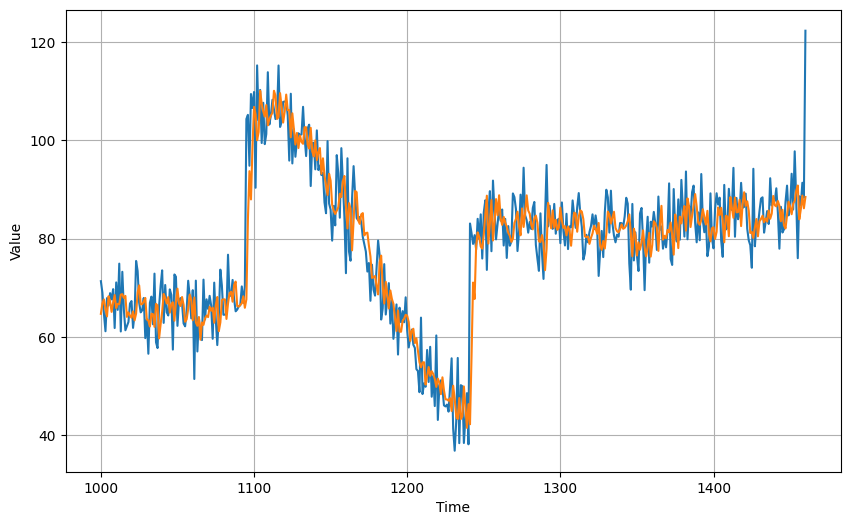

In [72]:
forecast = []

forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model_baseline.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

plot_series(time_valid, (x_valid, results))


In [73]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())


46.033894
4.9695063
